In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from vad_statistics import Statistics
import re

In [9]:
# find models

model_foldernames = {
    'penn' : {
        'vad' : "20190419 14-41-44 penn vad",
        'seq2seq' : "20190419 14-17-58 penn seq2seq",
        'bowman' : "20190419 16-43-15 penn bowman"
    },
    'amazon' : {
        'vad' : "20190419 13-10-52 amazon vad",
        'seq2seq' : "20190419 12-59-10 amazon seq2seq",
        'bowman' : "20190419 16-16-21 amazon bowman"
    },
    'subtitles' : {
        'vad' : "20190419 11-14-12 subtitles vad",
        'seq2seq' : "20190419 11-14-16 subtitles seq2seq",
        'bowman' : "20190419 17-01-17 subtitles bowman"
    }
}
parentFolder = "models"
lossFolders  = "results"

In [10]:
def loadResults(model_folder):
    """
    Loads csvs of all epochs from a given model_folder name.
    Returns a concatenation of results.
    """
    # setup filepath
    folder = os.path.join(parentFolder, model_folder, lossFolders)
    files = os.listdir(folder)

    # retrieve .csv files.
    if len(files) < 1: return

    # retrieve only csvs
    files = [i for i in files if (i[-4:].lower() == ".csv")]

    parts = re.match(r"([a-z]+_)([0-9]+)([a-z]+.csv)", files[-1], re.I).groups()

    # sort by epochs (increasing order)
    numbs = sorted([int(re.findall('\d+', i )[0]) for i in files])

    results = []
    for number in numbs:
        # create filename
        file = parts[0] + str(number) + parts[2]
        filepath = os.path.join(folder, file)

        ents = np.loadtxt(filepath, delimiter=", ")
        
        results.append(ents)
    return results

In [11]:
# load results
resultsData = {}
for dataset in model_foldernames.keys():
    for model in model_foldernames[dataset]:
        key = (dataset, model)
        resultsData[key] = {}
        folderpath = os.path.join(parentFolder, model_foldernames[dataset][model])
        losses = loadResults(model_foldernames[dataset][model])
        resultsData[key]['stats'] = losses
        # load bleu rouge
        try:
            with open(os.path.join(folderpath, "bleu_rouge.json"), "r") as f:
                resultsData[key]['bleu_rouge'] = json.load(f)
        except:
            pass

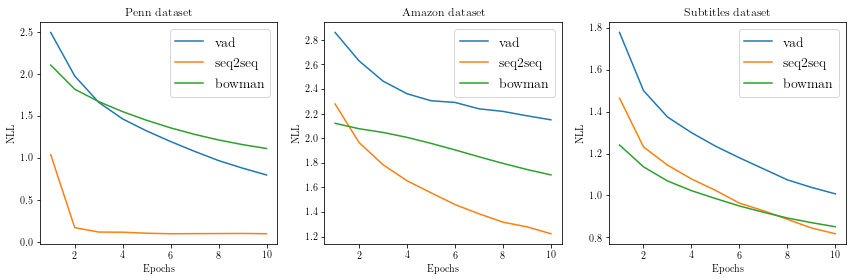

In [5]:
def chartLoss(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}
            
        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        meanLosses = []
        for epoch in epoch_losses:
            meanLosses.append(np.mean(epoch, axis=0))
        dataset_keys[key[0]][key[1]] = meanLosses
    
    # plot NLL losses
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = [result[0] for result in dataset_keys[dataset][model]]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("NLL")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
        
chartLoss(resultsData)

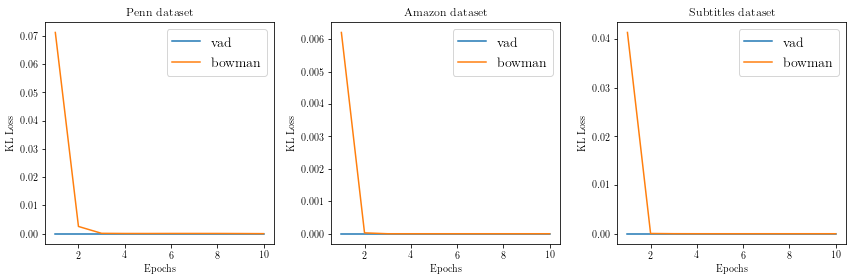

In [6]:
def getKLLoss(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        if key[-1] == "seq2seq":
            continue
 
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}

        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        KLLosses = []
        for epoch in epoch_losses:

            kl = epoch[:,1]
            KLLosses.append(np.mean(kl))
        dataset_keys[key[0]][key[1]] = KLLosses
        
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = dataset_keys[dataset][model]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("KL Loss")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
        
getKLLoss(resultsData)

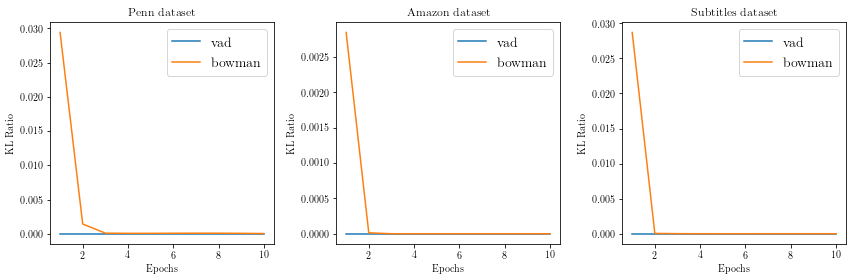

In [7]:
def getKLRatio(resultsData):
    
    dataset_keys = {}
    for key in resultsData:
        if key[-1] == "seq2seq":
            continue
 
        if key[0] not in dataset_keys:
            dataset_keys[key[0]] = {}

        epoch_losses = resultsData[key]['stats']
        # cols: loss, KL, BOW
        meanKL = []
        for epoch in epoch_losses:

            kl = epoch[:,1]
            nll = epoch[:,0]
            ratio = kl/nll
            meanKL.append(np.mean(ratio))
        dataset_keys[key[0]][key[1]] = meanKL
        
    fig, axes = plt.subplots(1,len(dataset_keys))
    fig.set_figheight(4)
    fig.set_figwidth(12)
    count = -1
    for dataset in dataset_keys:
        count += 1
        for model in dataset_keys[dataset]:
            epoch_size = len(dataset_keys[dataset][model])
            x = [i for i in range(1,epoch_size+1)]
            y = dataset_keys[dataset][model]
            axes[count].plot(x,y,label=model)
        axes[count].set_title(dataset.capitalize()+ " dataset")
        axes[count].set_xlabel("Epochs")
        axes[count].set_ylabel("KL Ratio")
        axes[count].legend()
    fig.tight_layout()
    fig.show()
        
getKLRatio(resultsData)

In [18]:
# need to do bleu/rouge
def chartBLEUROUGE(resultsData):
    for key in resultsData:
        k = resultsData[key]['bleu_rouge']
        print(key,k[0])

chartBLEUROUGE(resultsData)

('penn', 'vad') {'bleu': 0.09314509216776053, 'rouge_1': 1.8873268031221466, 'rouge_2': 0.08997157108744472, 'rouge_3': 0.017176778963784285, 'f1': 0.17752862784428836}
('penn', 'seq2seq') {'bleu': 0.6731546532579974, 'rouge_1': 1.4362008288762436, 'rouge_2': 1.2855705756339484, 'rouge_3': 1.1779983781169514, 'f1': 0.916664146142731}
('penn', 'bowman') {'bleu': 0.09311427969845477, 'rouge_1': 0.36701775666494946, 'rouge_2': 0.02235517000265834, 'rouge_3': 0.002212690128174063, 'f1': 0.14854255451758644}
('amazon', 'vad') {'bleu': 0.02147688523489328, 'rouge_1': 0.04925234028981569, 'rouge_2': 0.00871543221791243, 'rouge_3': 0.0, 'f1': 0.029910884845890145}
('amazon', 'seq2seq') {'bleu': 0.1865766993429981, 'rouge_1': 0.34991837907911216, 'rouge_2': 0.0853768446614926, 'rouge_3': 0.0026129388966054153, 'f1': 0.24338197621513208}
('amazon', 'bowman') {'bleu': 0.01519911042295522, 'rouge_1': 0.3632330113853087, 'rouge_2': 0.01008450715934333, 'rouge_3': 0.0, 'f1': 0.029177325766785885}
('

we need to chart Loss, KL Ratio, samples, variance of results, bleu/rouge